In [1]:
import qiskit
from qiskit import QuantumCircuit
import numpy as np
import copy
import time
from scipy.optimize import minimize
from typing import Optional, List, Dict, Tuple, Union
from qiskit.result import marginal_counts

from qiskit import pulse
from qiskit.providers.aer.pulse import duffing_system_model
from scipy.sparse import csr_matrix


import logging
logger = logging.getLogger()

# imports for qiskit dynamics simulation
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver
from qiskit.quantum_info.states import Statevector

# optimizers
from qiskit.algorithms.optimizers import SPSA
# other possible optimizer
# from scipy.optimize import fmin_l_bfgs_b
# from qiskit.algorithms.optimizers import QNSPSA

Imports needed from qiskit_nature

In [2]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
# Solvers
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver

# for HF calculation
from pyscf import scf
from pyscf import gto


Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


# Define the system Hamiltonian
We define the parameters of a duffling oscillator - which represent a superconducting based quantum computers.

The parameters used are relevant for a fixed frequency computers, like those used by IBM. 3 energy levels are taken into account in the simulation to simulate also leakage

In [3]:
from qiskit.providers.fake_provider import FakeManila
backend_manila = FakeManila()
manila_backend_config = backend_manila.configuration()
manila_ham_params = manila_backend_config.hamiltonian['vars']

In [4]:
# frequencies for transmon drift terms, harmonic term and anharmonic term
# Number of oscillators in the model is determined from len(oscillator_freqs)
manila_oscillator_freqs_2q = [manila_ham_params['wq0'] / (np.pi *2e9), 
                       manila_ham_params['wq1'] / (np.pi *2e9)] # numbers are in Ghz
manila_anharm_freqs_2q = [manila_ham_params['delta0'] / (np.pi *2e9),
                   manila_ham_params['delta1'] / (np.pi *2e9)] # numbers are in Ghz

# drive strengths
manila_drive_strengths_2q = [manila_ham_params['omegad0'] / (np.pi *2e9),
                      manila_ham_params['omegad1'] / (np.pi *2e9)] # numbers are in Ghz

# specify coupling as a dictionary
manila_coupling_dict_2q = {(0,1): manila_ham_params['jq0q1'] / (np.pi *2e9)} # numbers are in Ghz

# sample duration for pulse instructions
dt = 0.222 # numbers are in nano-seconds

# create the model
manila_model_3levels = duffing_system_model(dim_oscillators=3,
                                       oscillator_freqs=manila_oscillator_freqs_2q,
                                       anharm_freqs=manila_anharm_freqs_2q,
                                       drive_strengths=manila_drive_strengths_2q,
                                       coupling_dict=manila_coupling_dict_2q,
                                       dt=dt)

# Define functions to run the simulation

### translate pulses to driving signals and run a simulation

In [5]:
def destroy(N, offset=0):
    """Destruction (lowering) operator.
    Args:
        N (int): Dimension of Hilbert space.
        offset (int): (default 0) The lowest number state that is included
                      in the finite number state representation of the operator.
    Returns:
        Qobj: Qobj for lowering operator.
    Raises:
        ValueError: Invalid input.
    """
    if not isinstance(N, (int, np.integer)):  # raise error if N not integer
        raise ValueError("Hilbert space dimension must be integer value")
    data = np.sqrt(np.arange(offset + 1, N + offset, dtype=complex))
    ind = np.arange(1, N, dtype=np.int32)
    ptr = np.arange(N + 1, dtype=np.int32)
    ptr[-1] = N - 1
    return csr_matrix((data, ind, ptr), shape=(N, N)).toarray()

def create(N, offset=0):
    temp = destroy(N, offset)
    return temp.transpose().conj()

In [6]:
def run_ansatz(system_model, pulses, dt=0.222, initial_state=None, decoherence=False):
    hamiltonian_model = system_model.hamiltonian

    static_ham = \
    np.pi * (2 * hamiltonian_model._variables['v0'] - hamiltonian_model._variables['alpha0'])\
        * hamiltonian_model._system[0][0] + \
    np.pi * (2 * hamiltonian_model._variables['v1'] - hamiltonian_model._variables['alpha1'])\
        * hamiltonian_model._system[1][0] + \
    np.pi * hamiltonian_model._variables['alpha0'] * hamiltonian_model._system[2][0] +\
    np.pi * hamiltonian_model._variables['alpha1'] * hamiltonian_model._system[3][0] +\
    2 * np.pi * hamiltonian_model._variables['j01'] * hamiltonian_model._system[4][0]
  
    carrier_freqs = []
    ham_operators = []
    for channel in pulses.channels:
        if channel.name == 'd0':
            carrier_freqs.append(hamiltonian_model._variables['v0'])
            ham_operators.append(2 * np.pi * hamiltonian_model._variables['r0'] * \
                                   hamiltonian_model._system[5][0]) #D0
        elif channel.name == 'd1':
            carrier_freqs.append(hamiltonian_model._variables['v1'])
            ham_operators.append(2 * np.pi * hamiltonian_model._variables['r1'] * \
                                   hamiltonian_model._system[6][0]) #D1
        elif channel.name == 'u0':
            carrier_freqs.append(hamiltonian_model._variables['v1'])
            # CR parameters taken from hamiltonian tomography of the device
            a1 = -6
            a2 = 0.04
            a3 = -0.2
            
            XZ = np.kron((destroy(3) + create(3)), 0.5 * np.eye(3) - (create(3) @ destroy(3)))
            IZ = np.kron(np.eye(3), 0.5 * np.eye(3) - (create(3) @ destroy(3)))
            XI = np.kron((create(3) + destroy(3)), np.eye(3))
            
            ham_operators.append(hamiltonian_model._variables['r0'] * \
                                (a1 * IZ +
                                 a2 * XI + \
                                 a3 * XZ))
        elif channel.name == 'u1':
            carrier_freqs.append(hamiltonian_model._variables['v0'])
            
            a1 = -6
            a2 = 0.04
            a3 = -0.2
            
            ZX = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), (destroy(3) + create(3)))
            ZI = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), np.eye(3))
            IX = np.kron(np.eye(3), (create(3) + destroy(3)))
            
            ham_operators.append(hamiltonian_model._variables['r0'] * \
                                (a1 * ZI +
                                 a2 * IX + \
                                 a3 * ZX))

    signal_converter = InstructionToSignals(dt, carriers=carrier_freqs)

    try:
        ansatz_signals = signal_converter.get_signals(pulses)
    except:
        print("error in converting signal")
        print(pulses)
    
    dissipators_operators = []
    if decoherence:
        num_qubits = 2
        T1 = 100000
        T2 = 100000
        gamma_1 = 1 / T1
        gamma_2 = (1 / T2 + gamma_1 /2 ) /2
        X = create(3) + destroy(3) # extension to Operator.from_label('X')
        Y = 1j * (create(3) - destroy(3)) # extension to Operator.from_label('Y')
        Z = destroy(3) @ create(3) - create(3) @ destroy(3) # extension to Operator.from_label('Z')
        s_p = 0.5 * (X + 1j * Y)

        for qubit in range(num_qubits):
            zeros = Operator(np.zeros((3 ** num_qubits, 3 ** num_qubits)), 
                             input_dims=[3]*num_qubits, output_dims=[3]*num_qubits)
            dissipators_operators.append(zeros + Operator(np.sqrt(gamma_1) * s_p)(qubit))
            dissipators_operators.append(zeros + Operator(np.sqrt(gamma_2) * Z)(qubit))
            
        hamiltonian_solver = Solver(
            static_hamiltonian=static_ham,
            hamiltonian_operators=ham_operators,
            hamiltonian_signals=ansatz_signals,
            static_dissipators=dissipators_operators,
            rotating_frame=static_ham,
            rwa_cutoff_freq=2*hamiltonian_model._variables['v1']
        )
                        
    else:
        hamiltonian_solver = Solver(
            static_hamiltonian=static_ham,
            hamiltonian_operators=ham_operators,
            hamiltonian_signals=ansatz_signals,
            rotating_frame=static_ham,
            rwa_cutoff_freq=2*hamiltonian_model._variables['v1']
        )
    
    if initial_state is not None:
        init_state = initial_state
    else:
        groud_2q_3levels = Statevector([1., 0., 0., 0., 0., 0., 0., 0., 0.])
        init_state = groud_2q_3levels

    ansatz_res = hamiltonian_solver.solve(t_span=[0., pulses.duration*dt],
                                          y0=init_state, atol=1e-8, rtol=1e-8)
    return ansatz_res

### Calculate eigen-energy given measurement in the Molecule pauli bases

In [7]:
# define relevant functions
def expval_with_variance(counts,
                         operator_coeff: int,
                         diagonal: Optional[np.ndarray] = None,
                        finite_sampling=True) -> Tuple[float, float]:
    r"""Compute the expectation value of a diagonal operator from counts.

    Args:
        counts: counts object.
        diagonal: Optional, values of the diagonal observable. If None the
                  observable is set to :math:`Z^\otimes n`.

    Returns:
        (float, float): the expectation value and variance.
    """
    if finite_sampling:
        # Get counts shots and probabilities
        probs = np.array(list(counts.values()))
        shots = probs.sum()
        probs = probs / shots
        
        # Get diagonal operator coefficients
        if diagonal is None:
            coeffs = np.array([(-1) ** (key.count('1') % 2)
                               for key in counts.keys()])
        else:
            keys = [int(key, 2) for key in counts.keys()]
            coeffs = np.asarray(diagonal[keys])
            
        # Compute expval
        expval = coeffs.dot(probs)
        
        # Compute variance
        if diagonal is None:
            # The square of the parity diagonal is the all 1 vector
            sq_expval = np.sum(probs)
        else:
            sq_expval = (coeffs ** 2).dot(probs)
        variance = (sq_expval - expval ** 2) / shots
    else:
        probs = counts

        # Get diagonal operator coefficients
        if diagonal is None:
            coeffs = np.array([(-1) ** (key.count('1') % 2)
                               for key in probs.keys()])
        else:
            keys = [int(key, 2) for key in probs.keys()]
            coeffs = np.asarray(diagonal[keys])

        # Compute expval
        expval = coeffs.dot(list(probs.values()))

        # Compute variance
        if diagonal is None:
            # The square of the parity diagonal is the all 1 vector
            sq_expval = np.sum(list(probs.values()))
        else:
            sq_expval = (coeffs ** 2).dot(list(probs.values()))
        variance = (sq_expval - expval ** 2)# / shots

    # Compute standard deviation
    if variance < 0:
        if not np.isclose(variance, 0):
            logger.warning(
                'Encountered a negative variance in expectation value calculation.'
                '(%f). Setting standard deviation of result to 0.', variance)
        variance = 0.0
    return expval * operator_coeff, variance * abs(operator_coeff) ** 2

def calculate_accumulate_exp_val(probs, coeffs, finite_sampling):
    combined_expval = 0.0
    combined_variance = 0.0
    if type(probs) != list:
        probs = [probs]
    for ind, result in enumerate(probs):
        exp_val, exp_var = expval_with_variance(result, coeffs[ind], finite_sampling=finite_sampling)
        # Accumulate
        combined_expval += exp_val
        combined_variance += exp_var
    combined_stddev = np.sqrt(combined_variance)
    return combined_expval, combined_stddev

### Measure the simulation result in all the given pauli bases

In [8]:
hadamard = (1 / np.sqrt(2)) * np.array([[1,1],[1,-1]])
s_dg = np.array([[1,0],[0,1j]])
identity = np.array([[1,0],[0,1]])

def finite_sampling_measure(state, paulis, coeffs, leakage=False, shots=10000):
    ansatz_density_matrix = qiskit.quantum_info.DensityMatrix(state)
    if leakage:
        # filter out leakage
        reduced_density_matrix = qiskit.quantum_info.DensityMatrix(
            [list(ansatz_density_matrix.data[0][0:2]) + list(ansatz_density_matrix.data[0][3:5]),
             list(ansatz_density_matrix.data[1][0:2]) + list(ansatz_density_matrix.data[1][3:5]),
             list(ansatz_density_matrix.data[3][0:2]) + list(ansatz_density_matrix.data[3][3:5]),
             list(ansatz_density_matrix.data[4][0:2]) + list(ansatz_density_matrix.data[4][3:5])])
        leakage_prob = 1 - sum(reduced_density_matrix.probabilities())
        print("leakage percent: " + str(leakage_prob*100) + "%")
        ansatz_density_matrix = reduced_density_matrix / reduced_density_matrix.trace()

    # apply rotations to the result state
    results = [] 
    for pauli in paulis:
        measure_op = 1
        marginal_qubits = None
        for i, val in enumerate(reversed(pauli)):
            if val == 'Y':
                cur_measure_op = hadamard @ s_dg
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'X':
                cur_measure_op = hadamard
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'Z':
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'I': # we calculate expectation value, so we do not need to measure the identity
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
                marginal_qubits = 1 - i

        measured_density_matrix = ansatz_density_matrix.evolve(measure_op)

        if shots is not None:
            counts = measured_density_matrix.sample_counts(shots)
            if marginal_qubits is not None:
                counts = marginal_counts(counts, [marginal_qubits])
            results.append(counts)
            finite_sampling = True
        else:
            probs = measured_density_matrix.probabilities_dict()
            if marginal_qubits is not None:
                probs = marginal_counts(probs, [marginal_qubits])
            results.append(probs)
            finite_sampling=False
    
    expval, stddev = calculate_accumulate_exp_val(results, coeffs, finite_sampling)
    return expval, stddev

### the loss function - gets all the parameters and return the energy

In [9]:
def evaluate_energy(theta, paulis, coeffs, system_model, backend, dt=0.222, decoherence=False, shots=None):
    init_sched = create_ansatz(theta, dt, backend)
        
    print(theta)
    ansatz_result = run_ansatz(system_model, init_sched, dt, decoherence=decoherence)
    expval, stddev = finite_sampling_measure(ansatz_result.y[-1], paulis[1:], coeffs[1:], leakage=True, shots=shots)
    print("energy: " + str(expval + coeffs[0]))
    # in case I will want to return also the varience and the counts
    # return results, expval, stddev
    
    # save in global variables the mid-optimization values
    thetas.append(copy.deepcopy(theta))
    values.append(expval)
    states.append(ansatz_result.y[-1])
    return expval.real

a function that already have the static parameters hard-coded for easier use

In [10]:
def calculate_energy(theta):
    paulis = all_paulis[-1]
    coeffs = all_coeffs[-1]
    system_model = manila_model_3levels
    dt = 0.222
    shots = 10000
    decoherence = True
    backend = backend_manila
    energy = evaluate_energy(theta, paulis, coeffs, system_model, backend, dt, decoherence, shots)
    return energy

a function that gets multiple circuits and evaluates them one after the other and returns a best evaluation among them. useful for steepest hill climbing optimization

In [11]:
def evaluate_energy_simulation_multiple_circuits(circuits, paulis, coeffs, system_model, nuclear_repulsion_energy,
                                                 results_dict, dt=0.222, decoherence=False, shots=None):
    cur_step_energies = []
    for circ in circuits:
        ansatz_result = run_ansatz(system_model, circ, dt, decoherence=decoherence)
        expval, stddev = finite_sampling_measure(ansatz_result.y[-1], paulis[1:], coeffs[1:], 
                                                 leakage=True, shots=shots)
        print("energy: " + str(expval + coeffs[0]))
        # in case I will want to return also the varience and the counts
        # return results, expval, stddev

        # save in global variables the mid-optimization values
        energy = expval.real + coeffs[0] + nuclear_repulsion_energy
        results_dict["values"].append(energy)
        cur_step_energies.append(energy)
        print("energy with nuclear repulstion: " + str(energy))
        results_dict["stddev"].append(stddev)
        results_dict["states"].append(ansatz_result.y[-1])
    min_energy = min(cur_step_energies)
    return min_energy, cur_step_energies

# Define the ansatz

### First attempt

In [12]:
def amp_fun(pulse_duration, max_amp):
    return np.sign(pulse_duration) * min(abs(pulse_duration) / 20, max_amp)

def create_ansatz_old_function(theta, dt):
    """
    theta - durationa of drivea in ns
    CR pulses - triple weight
    """
    control_weight = 5
    
    drag0_1_dur = 54
    drag1_1_dur = 0
    control1_dur = int(control_weight * theta[0] / dt)

    drag0_2_dur = int(theta[1] / dt)
    drag1_2_dur = int(theta[2] / dt)
    # z rotations
    z0_1 = theta[3] / 10 # 1/10 weight
    z1_1 = theta[4] / 10 # 1/10 weight
    
    
    x_sigma = 64
    x_beta = -1.4
    x_amp = 0.2
    control_amp = 0.8
    control_width = abs(control1_dur)-14
    if control_width < 0:
        control_width = abs(control1_dur)
    
    with pulse.build() as ansatz_sol_sched:
        if drag0_1_dur != 0:
            pulse.play(pulse.Drag(abs(drag0_1_dur), amp_fun(drag0_1_dur, x_amp), x_sigma, x_beta),
                       pulse.DriveChannel(0))
        if drag1_1_dur != 0:
            pulse.play(pulse.Drag(abs(drag1_1_dur), amp_fun(drag1_1_dur, x_amp), x_sigma, x_beta),
                       pulse.DriveChannel(1))
        if drag0_1_dur != 0 or drag1_1_dur != 0:
            delay_1 = abs(drag1_1_dur)
            if abs(drag0_1_dur) > abs(drag1_1_dur):
                delay_1 = abs(drag0_1_dur)
            else:
                delay_1 = abs(drag1_1_dur)
            pulse.delay(delay_1, pulse.ControlChannel(0))
        else:
            delay_1 = 0
        pulse.play(pulse.GaussianSquare(duration=abs(control1_dur), amp=amp_fun(control1_dur, control_amp), sigma=64,
                                        width=control_width), pulse.ControlChannel(0))
        if drag0_2_dur != 0:
            pulse.delay(delay_1 - abs(drag0_1_dur) + abs(control1_dur), pulse.DriveChannel(0))
            pulse.shift_phase(z0_1, pulse.DriveChannel(0))
            pulse.play(pulse.Drag(abs(drag0_2_dur), amp_fun(drag0_2_dur, x_amp), x_sigma, x_beta), 
                       pulse.DriveChannel(0))
        if drag1_2_dur != 0:
            pulse.delay(delay_1 - abs(drag1_1_dur) + abs(control1_dur), pulse.DriveChannel(1))
            pulse.shift_phase(z1_1, pulse.DriveChannel(1))
            pulse.play(pulse.Drag(abs(drag1_2_dur), amp_fun(drag1_2_dur, x_amp), x_sigma, x_beta),
                       pulse.DriveChannel(1))
    return ansatz_sol_sched

### Generalize to multiple layers and account for echo in CR and hardware constrains

In real hardware each wavefunction must be a multiple of 16, and there is a minimum length for pulses. if the pulse is very short, replace the gaussian envelope of the single qubit pulses also to gaussian-squre, in order to avoid real hardware errors.

In [13]:
def create_pansatz_layer(two_qubit_durations, two_qubit_width, single_qubit_durations, 
                         x_amp, x_sigma, x_beta, control_amp, first_layer=False):
    single_qubit_drives = []
    two_qubit_drives = []
    two_qubit_tag_drives = []
    
    # two qubit pulses
    if not first_layer:
        for cur_dur, cur_width in zip(two_qubit_durations, two_qubit_width):
            if cur_dur != 0:
                two_qubit_drive = list(qiskit.pulse.library.gaussian_square(duration=abs(int(cur_dur/2)), 
                                                              amp=amp_fun(cur_dur/2, control_amp), sigma=64,
                                                              width=cur_width/2).samples)
                two_qubit_drive, _ = add_padding(two_qubit_drive)
                two_qubit_drives.append(two_qubit_drive)

                two_qubit_tag_drive = list(qiskit.pulse.library.gaussian_square(duration=abs(int(cur_dur/2)), 
                                                              amp=-1*amp_fun(cur_dur/2, control_amp), sigma=64,
                                                              width=cur_width/2).samples)
                two_qubit_tag_drive, _ = add_padding(two_qubit_tag_drive)
                two_qubit_tag_drives.append(two_qubit_tag_drive)
            else:
                two_qubit_drives.append([])
                two_qubit_tag_drives.append([])
    
    # single qubit pulses
    for cur_dur in single_qubit_durations:
        if cur_dur != 0:
            if abs(cur_dur) > 32:
                single_qubit_drive = list(qiskit.pulse.library.drag(abs(cur_dur), amp_fun(cur_dur, x_amp),
                                                 x_sigma, x_beta).samples)
                single_qubit_drive, _ = add_padding(single_qubit_drive)
                single_qubit_drives.append(single_qubit_drive)
            else:
                temp_width = abs(cur_dur) - 14
                if temp_width < 0:
                    temp_width = abs(cur_dur)
                single_qubit_drive = list(qiskit.pulse.library.gaussian_square(duration=abs(cur_dur), 
                                                                     amp=amp_fun(cur_dur, x_amp),
                                                                     sigma=x_sigma, 
                                                                     width=temp_width).samples)
                single_qubit_drive, _ = add_padding(single_qubit_drive)
                single_qubit_drives.append(single_qubit_drive)
        else:
            single_qubit_drives.append([])

    return two_qubit_drives, two_qubit_tag_drives, single_qubit_drives

def create_durations_and_widths(theta, dt, num_of_qubits, num_of_layers, initial_layer_param=[54, 0, 54, 0],
                                control_weight = 2.5, z_rotation_weight = 1/10):
    
    layers_durations = []
    layers_widths = []
    
    layers_durations.append({"single_qubit": initial_layer_param}) # layer 0
    layers_widths.append([]) # layer 0
    
    parameter_counter = 0
    for layer in range(num_of_layers):
        # two qubit pulses
        two_qubit_dur = []
        layer_width = []
        for channel in range(num_of_qubits-1):
            control_dur = int(control_weight * theta[parameter_counter] / dt)
            two_qubit_dur.append(control_dur)
            parameter_counter += 1
            # width calculation
            control_width = abs(control_dur)-14
            if control_width < 0:
                control_width = abs(control_dur)
            layer_width.append(control_width)
        layer_durations = {"two_qubit": two_qubit_dur}
        layers_widths.append(layer_width)
        
        # single qubit pulses
        single_qubit_dur = []
        for channel in range(num_of_qubits):
            single_qubit_dur.append(int(theta[parameter_counter] / dt))
            parameter_counter += 1
        layer_durations["single_qubit"] = single_qubit_dur
        single_qubit_phase_rotation = []
        for channel in range(num_of_qubits):
            single_qubit_phase_rotation.append(theta[parameter_counter] * z_rotation_weight)
            parameter_counter += 1
        layer_durations["single_qubit_phase"] = single_qubit_phase_rotation
        
        layers_durations.append(layer_durations)
    
    return layers_durations, layers_widths

In [14]:
def amp_fun(pulse_duration, max_amp):
    return np.sign(pulse_duration) * min(abs(pulse_duration) / 20, max_amp)

def add_padding(waveform_samples, before=False):
    if len(waveform_samples) == 0:
        return waveform_samples, 0
    padding_to_add = 16 - (len(waveform_samples) % 16)
    if before:
        new_samples = [0.] * padding_to_add + waveform_samples
    else:
        new_samples = waveform_samples + [0.] * padding_to_add
    if len(new_samples) < 64:
        if before:
            new_samples = [0.] * (64 - len(new_samples)) + new_samples
        else:
            new_samples = new_samples + [0.] * (64 - len(new_samples))
    return new_samples, len(new_samples) - len(waveform_samples)

def create_ansatz(theta, dt, backend, layers=1, qubits=[0,1]):
    """
    theta - durations of drives in ns
    """
    control_weight = 2.5
    z_rotation_weight = 1/10
    flip_duration = 54
    
    backend_channels = backend.configuration().to_dict()['channels']
    for channel in backend_channels:
        if backend_channels[channel]['operates']['qubits'] == [qubits[0], qubits[1]]:
            control_channel_0 = int(channel.split('u')[1])
    control_channels = [control_channel_0]
    
    
    x_sigma = 64
    x_beta = -1.4
    x_amp = 0.2
    control_amp = 0.8
    
    layers_durations, layers_widths = create_durations_and_widths(theta, dt, len(qubits), layers, 
                                                                  [54, 0], # initial layer params
                                                                  control_weight, z_rotation_weight)
    
    single_qubit_drives = []
    two_qubit_drives = []
    two_qubit_tag_drives = []
    single_qubit_delays = []
    
    single_channels_times = {}
    for qubit in qubits:
        single_channels_times[qubit] = 0
    control_channels_times = [0] * len(control_channels)
    current_time = 0
    
    with pulse.build() as ansatz_sol_sched:        
        ###################
        ##### Layer 0 #####
        ###################
        # initial 1 qubit pulses
        _, _, single_qubit_drives_0 = \
            create_pansatz_layer([],
                                 [],
                                 layers_durations[0]["single_qubit"], 
                                 x_amp, x_sigma, x_beta, control_amp, first_layer=True)
        
        ########################
        ##### Other Layers #####
        ########################
        two_qubit_drives = []
        two_qubit_tag_drives = []
        single_qubit_drives = []

        for layer in range(1, layers+1):
            temp_two_qubit_drives, temp_two_qubit_tag_drives, temp_single_qubit_drives = \
                create_pansatz_layer(layers_durations[layer]["two_qubit"],
                                     layers_widths[layer],
                                     layers_durations[layer]["single_qubit"],
                                     x_amp, x_sigma, x_beta, control_amp)
            two_qubit_drives.append(temp_two_qubit_drives)
            two_qubit_tag_drives.append(temp_two_qubit_tag_drives)
            single_qubit_drives.append(temp_single_qubit_drives)
            
        #######################
        ##### Flip Pulses #####
        #######################
        flip_plus = list(qiskit.pulse.library.drag(flip_duration, 2*amp_fun(flip_duration, x_amp),
                                                 x_sigma, x_beta).samples)
        flip_minus = list(qiskit.pulse.library.drag(flip_duration, -2*amp_fun(flip_duration, x_amp),
                                                 x_sigma, x_beta).samples)
        
        #################################
        ##### Creating the schedule #####
        #################################
        
        # add padding to flip pulses
        flip_plus, _ = add_padding(flip_plus)
        flip_minus, _ = add_padding(flip_minus)
        # initial layer
        for qubit_num in range(len(qubits)):
            pulse.play(pulse.Waveform(single_qubit_drives_0[qubit_num]), pulse.DriveChannel(qubits[qubit_num]))
            single_channels_times[qubits[qubit_num]] += len(single_qubit_drives_0[qubit_num])
        current_time = max(single_channels_times.values())
        # the rest of the layers
        for layer_num, (two_qubit_drive, two_qubit_tag_drive, single_qubit_drive) in\
            enumerate(zip(two_qubit_drives, two_qubit_tag_drives, single_qubit_drives)):
            # two qubit pulses
            # first do layer with control in even numbered qubits and than the alternating layer with
            # control in the odd numbered qubits
            for alternating_index in [0, 1]:
                for control_index in range(alternating_index, len(two_qubit_drive), 2):
                    if len(two_qubit_drive[control_index]) > 0:
                        temp_time = current_time
                        
                        pulse.delay(temp_time - control_channels_times[control_index],
                                    pulse.ControlChannel(control_channels[control_index]))
                        control_channels_times[control_index] += temp_time
                        pulse.play(pulse.Waveform(two_qubit_drive[control_index]), 
                                   pulse.ControlChannel(control_channels[control_index]))
                        temp_time += len(two_qubit_drive[control_index])
                        control_channels_times[control_index] = temp_time
                        # flip pulse
                        pulse.delay(temp_time - single_channels_times[qubits[control_index]], 
                                    pulse.DriveChannel(qubits[control_index]))
                        pulse.play(pulse.Waveform(flip_plus), pulse.DriveChannel(qubits[control_index]))
                        temp_time += len(flip_plus)
                        single_channels_times[qubits[control_index]] = temp_time
                        # echoed part
                        pulse.delay(temp_time - control_channels_times[control_index], 
                                    pulse.ControlChannel(control_channels[control_index]))
                        pulse.play(pulse.Waveform(two_qubit_tag_drive[control_index]), 
                                   pulse.ControlChannel(control_channels[control_index]))
                        temp_time += len(two_qubit_tag_drive[control_index])
                        control_channels_times[control_index] = temp_time
                        # unflip pulse
                        pulse.delay(temp_time - single_channels_times[qubits[control_index]],
                                    pulse.DriveChannel(qubits[control_index]))
                        pulse.play(pulse.Waveform(flip_minus), pulse.DriveChannel(qubits[control_index]))
                        temp_time += len(flip_minus)
                        single_channels_times[qubits[control_index]] = temp_time
                current_time = max(single_channels_times.values())

            # single qubit pulses   
            for qubit_num in range(len(qubits)):
                pulse.delay(current_time - single_channels_times[qubits[qubit_num]],
                                pulse.DriveChannel(qubits[qubit_num]))
                # layers start from 1
                pulse.shift_phase(layers_durations[layer_num+1]["single_qubit_phase"][qubit_num],
                                  pulse.DriveChannel(qubits[qubit_num]))
                pulse.play(pulse.Waveform(single_qubit_drive[qubit_num]), pulse.DriveChannel(qubits[qubit_num]))
                single_channels_times[qubits[qubit_num]] += (current_time - \
                                                                 single_channels_times[qubits[qubit_num]] +\
                                                                 len(single_qubit_drive[qubit_num]))
            current_time = max(single_channels_times.values())
                
    return ansatz_sol_sched

### Steepest hill climbing - build circuits for a step
Function which builds circuits for a whole step of steepest hill climbing

In [15]:
def create_optimization_step_circuits(parameters, change_param_index, change_param_range, backend, 
                                      qubits, results_dict, layers=3, dt=0.222):
    circuits = []
    for param_change in change_param_range:
        temp_param_vector = copy.deepcopy(parameters)
        if change_param_index in [0, 1, 2]: # duration and not Rz angle
            param_change = param_change * dt
        temp_param_vector[change_param_index] += param_change
        # build the ansatz
        ansatz = create_ansatz(temp_param_vector, dt, backend, layers=layers, qubits=qubits)
        # for real device, should call "create_circuits" to add measurement operations and later transpile
        circuits.append(ansatz)
        results_dict["thetas"].append(temp_param_vector)
    return circuits

# Functions to build the problem parameters

In [16]:
def get_qubit_op(dist, mapper="parity"):
    molecule = Molecule(geometry=[["He", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, dist]]], charge=1, multiplicity=1)
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
    es_problem = ElectronicStructureProblem(driver)
    second_q_op = es_problem.second_q_ops()
    if mapper == "parity":
        qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    elif mapper == "jordan":
        qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
    elif mapper == "bravi":
        qubit_converter = QubitConverter(mapper=BravyiKitaevMapper(), two_qubit_reduction=True)
    else:
        print("mapper should be one of parity, jordan or bravi")
        return None
    qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
    return qubit_op, es_problem

In [17]:
def get_hf_energy(dist):
    temp_mol = gto.M(atom = 'H 0 0 0; H 0 0 ' + str(dist), basis = 'sto3g')
    temp_hf = scf.HF(temp_mol)
    return temp_hf.kernel()

In [18]:
def get_accurate_state(dist):
    temp_qubit_op = get_qubit_op(dist)[0]
    eigen_values, eigen_vectors = np.linalg.eigh(temp_qubit_op.to_matrix())
    min_eigen_value = eigen_values[0]
    min_eigen_vector = eigen_vectors.transpose()[0]
    return min_eigen_value, min_eigen_vector

In [19]:
def get_exact_energies(dist):
    numpy_solver = NumPyMinimumEigensolver()
    qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    _, es_prob = get_qubit_op(dist)
    temp_res = calc.solve(es_prob)
    return temp_res, temp_res.total_energies[0], temp_res.nuclear_repulsion_energy

In [20]:
def get_paulis_and_coeffs(dist):
    qubit_op = get_qubit_op(dist)[0]
    paulis = []
    for op in qubit_op:
        paulis.append(str(op)[-op.num_qubits:])
    return paulis, qubit_op.coeffs

# Visualization functions

In [21]:
def plot_energies(exact_energies, exp_energies, distances):
    fig = plt.figure(figsize=(8, 5))
    plt.plot(distances, exact_energies, lw=3, label="Exact Energy")
    plt.plot(distances, exp_energies, lw=3, label="Exp Energy")
    plt.fill_between(distances, np.array(exact_energies)-0.0016, np.array(exact_energies)+0.0016, 
                     alpha=0.2, facecolor='#089FFF', label="Chemical accuracy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()

In [22]:
def plot_energies_error(exact_energies, exp_energies, distances):
    fig = plt.figure(figsize=(8, 5))
    plt.plot(distances, np.abs(np.array(exact_energies) - np.array(exp_energies)), lw=3, label="Exp Error")
    plt.axhline(0.0016, linestyle='--', label="Chemical accuracy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy Error')
    plt.legend()
    plt.show()

In [23]:
def plot_convergence(values_hist_arr, dist):
    values_hist_arr_real = np.array(values_hist_arr[dist])
    paulis, coeffs = get_paulis_and_coeffs(dist)
    values_hist_arr_real = values_hist_arr_real + coeffs[0]
    values_hist_arr_real = np.array([spsa_value.real for spsa_value in values_hist_arr_real])
    
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
    min_eigenvalue = min_energy - nuclear_repulsion_energy

    fig = plt.figure(figsize=(8, 5))
    plt.plot(list(range(len(values_hist_arr[dist]))), values_hist_arr_real , lw=3, label="energy")
    plt.plot(list(range(len(values_hist_arr[dist]))), [min_eigenvalue] * len(values_hist_arr_real) , 'k', lw=3, 
             label="optimal energy", linestyle="dashed")
    plt.xlabel("iteration")
    plt.ylabel("Energy")
    plt.legend(frameon=False)
    plt.title("H_2 SPSA convergence")
    plt.show()

In [24]:
def plot_populations_2q_leak(sol_vec, time):
    popu = [psi.probabilities() for psi in sol_vec]
    popu = np.array(popu).transpose()
    leakage = popu[2] + popu[5] + popu[6] + popu[7] + popu[8]

    fig = plt.figure(figsize=(8, 5))
    plt.plot(time, popu[0], lw=3, label="Population in |00>")
    plt.plot(time, popu[1], lw=3, label="Population in |01>")
#     plt.plot(time, popu[2], lw=3, label="Population in |02>")
    plt.plot(time, popu[3], lw=3, label="Population in |10>")
    plt.plot(time, popu[4], lw=3, label="Population in |11>")
    plt.plot(time, leakage, lw=3, label="leakage")
#     plt.plot(time, popu[5], lw=3, label="Population in |12>")
#     plt.plot(time, popu[6], lw=3, label="Population in |20>")
#     plt.plot(time, popu[7], lw=3, label="Population in |21>")
#     plt.plot(time, popu[8], lw=3, label="Population in |22>")
    plt.xlabel("Time (ns)")
    plt.ylabel("Population")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])

# Run the optimization

In [25]:
dists = [0.3, 0.5, 0.7, 0.8, 1, 1.5, 2, 3]

thetas_hist = {}
values_hist = {}
states_hist = {}
all_paulis = []
all_coeffs =[]

all_nuclear_repulsion_energies = {}
all_identity_coeff = {}
exact_energies = []

iterations_per_dist = 2

for dist in dists:
    print("#########################################")
    print("Solving for distance " + str(dist) + ":")
    print("#########################################")
    paulis, coeffs = get_paulis_and_coeffs(dist)
    all_paulis.append(paulis)
    all_coeffs.append(coeffs)
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
    target_energy = min_energy - nuclear_repulsion_energy
    all_nuclear_repulsion_energies[dist] = nuclear_repulsion_energy
    all_identity_coeff[dist] = coeffs[0]
    exact_energies.append(min_energy)

    initial_theta = [0, 54 * dt, 0, 0, 0]

    learning_rate1 = [3, 2, 2, 1, 1, 1]
    learning_rate2 = [0.5] * 5
    learning_rate3 = [0.2] * 5
    learning_rate4 = [0.1] * 5
    learning_rate5 = [0.05] * 70
    learning_rate = learning_rate1 + learning_rate2 + learning_rate3 + learning_rate4 + learning_rate5

    perturbation1 = [3*dt, 3*dt, 3*dt, 3*dt]
    perturbation2 = [2*dt] * 5
    perturbation3 = [1*dt] * 70
    perturbation = perturbation1 + perturbation2 + perturbation3

    thetas = []
    values = []
    states = []

    tic = time.perf_counter()
    spsa = SPSA(maxiter=iterations_per_dist, learning_rate=learning_rate, perturbation=perturbation)
    vqe_result = spsa.minimize(calculate_energy, initial_theta)
    toc = time.perf_counter()

    thetas_hist[dist] = copy.deepcopy(thetas)
    values_hist[dist] = copy.deepcopy(values)
    states_hist[dist] = copy.deepcopy(states)

    opt_theta_index = values.index(np.min(values))

    print(f"Finished the VQE in {toc - tic:0.4f} seconds")
    print("final theta: " + str(thetas[opt_theta_index]))
    res = min(values).real + coeffs[0]
    print("min eigen_value found: " + str(res))
    print("absolute error: " + str(np.abs(res - target_energy)))
    print("number of function evaluations: " + str(vqe_result.nfev))
    opt_sched = create_ansatz(thetas[opt_theta_index], dt, backend_manila)
    print("solution schedule duration: " + str(opt_sched.duration * dt) + " [ns]")

#########################################
Solving for distance 0.3:
#########################################
[-0.666 12.654  0.666 -0.666 -0.666]
leakage percent: 0.04189524585332949%
energy: (-5.296425294853802+0j)
[ 0.666 11.322 -0.666  0.666  0.666]
leakage percent: 0.018502891582627967%
energy: (-5.301373851548749+0j)
[ 0.6771454 11.3108546  0.6548546 -0.6548546 -0.6548546]
leakage percent: 0.02252214373598127%
energy: (-5.301873311463141+0j)
[-0.6548546 12.6428546 -0.6771454  0.6771454  0.6771454]
leakage percent: 0.03733035699982068%
energy: (-5.3042108304256+0j)
[ 7.63560973e-03  1.19803644e+01 -1.46551862e-02  1.46551862e-02
  1.46551862e-02]
leakage percent: 0.021161593027585468%
energy: (-5.312423600346333+0j)
Finished the VQE in 116.0658 seconds
final theta: [ 7.63560973e-03  1.19803644e+01 -1.46551862e-02  1.46551862e-02
  1.46551862e-02]
min eigen_value found: (-5.312423600346333+0j)
absolute error: 0.014497540304821754
number of function evaluations: 4
solution schedule 

## Plot the results

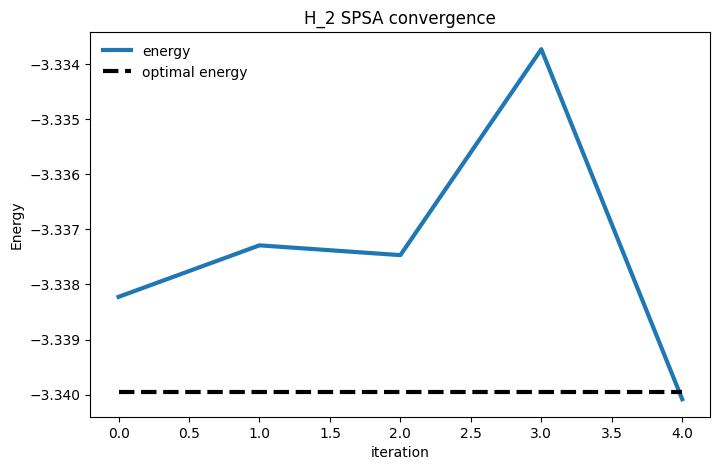

In [30]:
plot_convergence(values_hist, 2)

In [27]:
exp_energies = []
for dist in dists:
    exp_energies.append(
        (np.min(values_hist[dist]) + all_identity_coeff[dist] + all_nuclear_repulsion_energies[dist]).real)

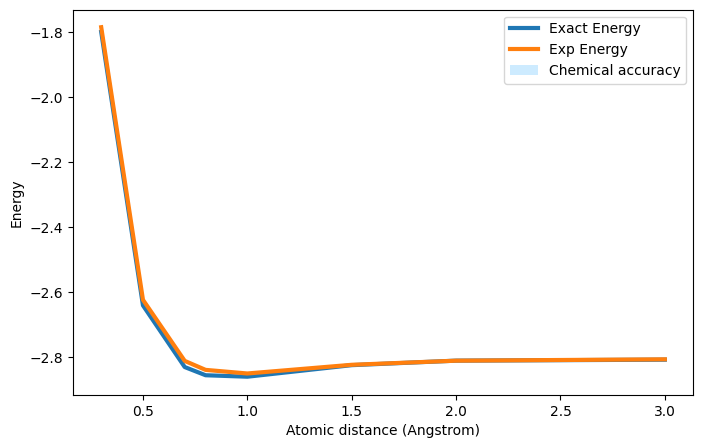

In [28]:
plot_energies(exact_energies, exp_energies, dists)

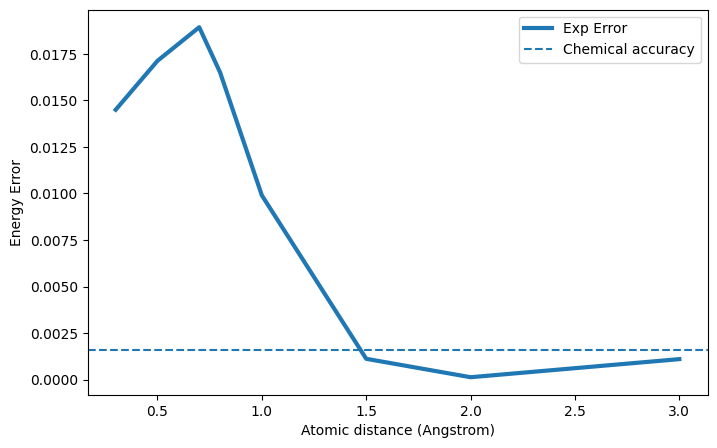

In [29]:
plot_energies_error(exact_energies, exp_energies, dists)

# Test another optimization algorithm - steepest hill climbing optimization

In [ ]:
dists = [0.3, 0.5, 0.7, 0.8, 1, 1.5, 2, 3]


results_dict = {}

all_paulis = []
all_coeffs = []
exact_energies = []

backend = backend_manila
system_model = manila_model_3levels
qubits = [0,1]
shots = 10000
dt = 0.222
decoherence = True
layers = 1

number_of_iterations = 4

for dist in dists:
    print("#########################################")
    print("Solving for distance " + str(dist) + ":")
    print("#########################################")
    paulis, coeffs = get_paulis_and_coeffs(dist)
    all_paulis.append(paulis)
    all_coeffs.append(coeffs)
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
    target_energy = min_energy
    exact_energies.append(target_energy)

    initial_theta = [0, 54 * dt, 0, 0, 0]
    
    parameter_search_space = {
        "0": np.linspace(20, -20, 21),
        "1": np.linspace(30, -30, 21),
        "2": np.linspace(30, -30, 21),
        "3": np.linspace(4, -4, 17),
        "4": np.linspace(4, -4, 17)
    }   
    
    parameters_order = [0, 1, 2, 3, 4]

    cur_dist_res_dict = {"all_runs": {"values": [], "thetas": [], "stddev": [], "states": []},
                         "steps": {"min_energies": [], "min_std": [], "thetas": {}}
                        }
    results_dict[dist] = cur_dist_res_dict

    cur_theta = copy.deepcopy(initial_theta)
    cur_energy = 10
    cur_stddev = 0
    
    tic = time.perf_counter()
    for i in range(number_of_iterations):
        if i >= 2:
            parameter_search_space = {
                "0": np.linspace(5, -5, 11),
                "1": np.linspace(5, -5, 11),
                "2": np.linspace(5, -5, 11),
                "3": np.linspace(0.5, -0.5, 11),
                "4": np.linspace(0.5, -0.5, 11)
            }
        for param_index in parameters_order:
            print("theta: " + str(cur_theta))
            print("working on theta[" + str(param_index) + "]")
            cur_step_circuits = create_optimization_step_circuits(cur_theta, param_index, 
                                                                  parameter_search_space[str(param_index)], 
                                                                  backend, qubits, 
                                                                  cur_dist_res_dict["all_runs"], layers=layers, dt=dt)
            
            step_min_energy, cur_step_energies = evaluate_energy_simulation_multiple_circuits(cur_step_circuits, 
                                                            paulis, coeffs, system_model, 
                                                            nuclear_repulsion_energy, cur_dist_res_dict["all_runs"], 
                                                            dt=dt, decoherence=decoherence, shots=shots)
            print("min energy found: " + str(step_min_energy))
            cur_dist_res_dict["steps"]["min_energies"].append(step_min_energy)
            opt_energy_index = cur_step_energies.index(step_min_energy)
            cur_step_std = cur_dist_res_dict["all_runs"]["stddev"][-len(cur_step_energies):]
            cur_dist_res_dict["steps"]["min_std"] = cur_step_std[opt_energy_index]
            if step_min_energy < cur_energy:
                cur_energy = step_min_energy
                cur_stddev = cur_step_std[opt_energy_index]
                if param_index in [0, 1, 2]:
                    multiplier = dt
                else:
                    multiplier = 1
                cur_theta[param_index] = cur_theta[param_index] + \
                    parameter_search_space[str(param_index)][opt_energy_index] * multiplier
            cur_dist_res_dict["steps"]["theta"] = copy.deepcopy(cur_theta)
            print("updated theta: " + str(cur_theta))
    
    toc = time.perf_counter()

    opt_theta_index = values.index(np.min(values))

    print(f"Finished the VQE in {toc - tic:0.4f} seconds")
    print("final theta: " + str(cur_theta))
    print("min eigen_value found: " + str(cur_energy))
    print("absolute error: " + str(np.abs(cur_energy - target_energy)))
    print("std: " + str(cur_stddev))
    print("number of iterations: " + str(i))
    opt_sched = create_ansatz(cur_theta, dt, backend, layers=layers, qubits=qubits)
    print("solution schedule duration: " + str(opt_sched.duration * dt) + " [ns]")

## Plot the results

In [ ]:
exp_energies_steepest_hill = []
for dist in dists:
    exp_energies_steepest_hill.append(np.min(results_dict[dist]['steps']['min_energies']).real)

In [ ]:
plot_energies(exact_energies, exp_energies_steepest_hill, dists)

In [ ]:
plot_energies_error(exact_energies, exp_energies, dists)

### The versions of packages used in this notebook

In [35]:
import qiskit.tools.jupyter
%qiskit_version_table

In [36]:
import qiskit_dynamics
qiskit_dynamics.__version__

'0.2.1'